“Text Summarization using Graph-Based TextRank Algorithm”

🎯 Project Goal

Develop an algorithm that automatically summarizes long texts by identifying and extracting the most important Articles, using a graph-based ranking approach inspired by Google’s PageRank.

So, so far the algorithms are : 1-graph 2- sorting and ranking

⚙️ Algorithm (Summary)

Input: text string, number of summary Articles 
𝑘
k

Output: top-
𝑘
k ranked Articles (summary)

Pseudocode:

1. Split the input text into Articles S = [s1, s2, ..., sn]
2. Clean and tokenize each Article (remove stopwords, punctuation)
3. For each pair (i, j), compute similarity sim(si, sj)
4. Build weighted graph G with edges (i, j, sim)
5. Initialize ranks Ri = 1/n for all Articles
6. Repeat until convergence:
       Ri_new = (1 - d) + d * sum_j( wji / sum_k(wjk) * Rj )
7. Sort Articles by Ri descending
8. Select top-k and preserve original order
9. Return the selected Articles as summary

| Stage                 | Complexity       | Notes                                    |
| --------------------- | ---------------- | ---------------------------------------- |
| Article tokenization | (O(n))           | n = # of Articles                       |
| Pairwise similarity   | (O(n^2 \cdot L)) | L = avg Article length                  |
| Graph iteration       | (O(n^2 \cdot T)) | T = # of iterations (~20–50)             |
| Total                 | (O(n^2))         | Feasible for up to hundreds of Articles |


Data structure choice:

Articles: list of strings

Tokens: list of words per Article

Graph: adjacency list {i: [(j, weight)]}

Ranks: dict or list [float]

🧪 Implementation Plan
Phase 1 — Core Algorithm (Toy Example)

Hardcode one or two small paragraphs.

Implement tokenization, similarity, and iterative rank update with pure Python only.

Print final Article scores and summary.

Phase 2 — Full Dataset

Load multiple news articles (e.g., BBC dataset on Kaggle
)

Use same algorithm; you may use NumPy for matrix ops only at this stage.

Phase 3 — Evaluation

Qualitative: Does summary capture the main idea?

Quantitative (optional): Compute ROUGE-1 or ROUGE-L if reference summaries available.

Compare variants:

Word overlap vs. cosine TF–IDF similarity

With/without stopwords

Different damping factors (0.85 vs 0.9)

🪄 Possible Extensions (for bonus points / CV polish)

Add redundancy penalty (avoid similar top Articles).

Try phrase-based summarization (extract key noun phrases).

Visualize the Article graph using networkx later (not needed for the toy).

Build a command-line tool:

🧮 Practical Tips

Start small: Pick ~10 articles to debug, because computing pairwise Article similarity for large docs can be heavy in pure Python.

Article length cutoff: Ignore Articles shorter than 5 words or longer than 50 words to clean noise.

Stopwords: Create a small stopword list manually (common English words).

Evaluation: Compare your top-k extracted Articles against highlights. You can check for keyword overlap or compute simple recall of key nouns.

#### **DATA**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# data = pd.read_csv("c:\\Users\\farno\\Documents\\UNITOSTUDY\\Algorithm\\TheShorterVersion\\Data\\cnn_dailymail\\train.csv")
# toy_set = data.sample(5, random_state=42)
# toy_set.to_csv("toy.csv", index=False)
    

In [2]:
toy_set = pd.read_csv("c:\\Users\\farno\\Documents\\UNITOSTUDY\\Algorithm\\TheShorterVersion\\toy.csv")

In [3]:
toy_set

,id,article,highlights
0,ed0fed726929c1eeabe6c390e47128dbb7d7a055,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
1,023cd84001b33aed4ff0f3f5ecb0fdd2151cf543,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
2,6a70a0d8d3ed365fe1df6d35f1587a8b9b298618,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
3,b37204c13ea38b511265e41ac69fb12acfb63f85,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
4,c24e5805afd5145bc48410e876db91d44a06be5e,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...


### **TOKENIZING AND CLEANING**

We'll focus on the first article text and implement the custom (package-free) functions to perform Article and word tokenization, along with cleaning (lowercasing, punctuation removal, and stop word filtering).

1. Mathematical Concept: Text Preprocessing
This step doesn't involve complex mathematics yet, but it forms the basis for the later calculation of edge weights (w 
ij
​
 ). By normalizing the text (lowercasing) and reducing the vocabulary to significant terms (removing stop words), we ensure the later similarity calculation is meaningful and isn't skewed by common, non-informative words like 'the' or 'a'.

The splitting approach used in the manual_clean_and_tokenize_words function is **Whitespace Tokenization** (or Delimiter-Based Splitting), coupled with explicit Punctuation Removal.
he approach is: Punctuation → Space Replacement → Whitespace Tokenization. This is a simple, effective, and completely package-free method for transforming a clean sentence string into a list of word tokens.( "This is how a sentence will be a list of words") 
**How we seperate the sentences**? The only using of . has limitations. So we wrote a function to go deeper.



In [4]:
################################################################(NEW)
# --- GLOBAL SETUP (NO PACKAGES) ---

article_text_input = (
    "By . Mia De Graaf . Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul. "
    "People enjoyed temperatures of 17C at Brighton, East Sussex, which was just shy of the year's record of 18C, set in Wales last month. "
    "Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade. "
    "Sun-worshippers took to parks and gardens across the country as the bank holiday weekend officially got underway."
)

# Generalized STOP WORDS List (Covers core function words, verbs, and pronouns)
STOP_WORDS = {
    'the', 'a', 'an', 'and', 'or', 'is', 'are', 'was', 'were', 'of', 'in', 'to', 
    'for', 'on', 'with', 'at', 'by', 'as', 'it', 'its', 'from', 'be', 'has', 'have',
    # Pronouns & Determiners
    'i', 'me', 'my', 'we', 'our', 'us', 'you', 'your', 'he', 'him', 'his', 'she', 'her', 
    'they', 'them', 'their', 'this', 'that', 'these', 'those', 's',
    # Adverbs, Prepositions, Conjunctions
    'up', 'down', 'out', 'off', 'into', 'without', 'about', 'just', 'which', 'who',
    'whom', 'what', 'where', 'when', 'why', 'how', 'than', 'while', 'because',
    'but', 'if', 'then', 'so', 'such', 'only', 'before', 'after', 'too', 'very', 
    # Auxiliary & Modal Verbs
    'do', 'does', 'did', 'would', 'should', 'could', 'will', 'can', 'not', 'being', 
    'been', 'am', 'shall', 'may', 'might'
}

# --- Small helper resources (still no external packages) ---
# Common abbreviations to avoid false sentence splits
ABBREV = {
    "mr.", "mrs.", "ms.", "dr.", "prof.", "sr.", "jr.", "st.", "no.",
    "u.s.", "u.k.", "e.g.", "i.e.", "jan.", "feb.", "mar.", "apr.", "jun.",
    "jul.", "aug.", "sep.", "sept.", "oct.", "nov.", "dec."
}

# Simple boilerplate patterns to strip from the beginning
def strip_boilerplate_start(text):
    t = text.strip()
    # "By . Name ."
    if t.lower().startswith("by . "):
        # remove up to the next " . "
        # find second " . "
        first = t.lower().find(" . ")
        if first != -1:
            second = t.lower().find(" . ", first + 3)
            if second != -1:
                t = t[second + 3 : ].lstrip()
    # "(CNN) --", "(CNN) —"
    lower = t.lower()
    if lower.startswith("(cnn) --") or lower.startswith("(cnn) —") or lower.startswith("(cnn) -"):
        idx = t.find(")")
        if idx != -1:
            # skip ) and following dashes/spaces
            j = idx + 1
            while j < len(t) and t[j] in "-—– ":
                j += 1
            t = t[j:].lstrip()
    # "PUBLISHED: ..." at start
    if lower.startswith("published:"):
        # cut to first period after "published:"
        dot = t.find(".")
        if dot != -1:
            t = t[dot+1:].lstrip()
    return t

# --- 1. HYPER-MANUAL SENTENCE TOKENIZATION (SMART HEURISTICS) ---
def manual_tokenize_Articles(text):
    """
    Smarter sentence splitting:
    - handles ., ?, !
    - avoids splitting after common abbreviations (u.s., dr., etc.)
    - splits even when quotes/brackets follow a terminator
    - strips common news boilerplate at the very start
    """
    text = strip_boilerplate_start(text)

    TEMP_DELIMITER = "@@@"
    QUOTES_OR_BRACKETS = set('"\'()[]{}')
    TERMINATORS = {'.', '?', '!'}

    processed = []
    N = len(text)
    i = 0

    def is_upper_letter(c):
        return 'A' <= c <= 'Z'

    while i < N:
        ch = text[i]

        if ch in TERMINATORS:
            # look ahead to next non-space
            j = i + 1
            while j < N and text[j].isspace():
                j += 1

            # skip immediate quotes/brackets then spaces
            k = j
            while k < N and text[k] in QUOTES_OR_BRACKETS:
                k += 1
                while k < N and text[k].isspace():
                    k += 1

            # find last token before the terminator (to check abbreviation)
            left = i - 1
            while left >= 0 and text[left].isspace():
                left -= 1
            start = left
            while start >= 0 and not text[start].isspace():
                start -= 1
            last_token = text[start+1:i+1].lower() if i >= 0 else ""

            # decide if we should split here
            should_split = True
            if last_token in ABBREV:
                should_split = False
            else:
                if k < N:
                    should_split = is_upper_letter(text[k])
                else:
                    should_split = True  # end of text

            if should_split:
                processed.append(ch)          # Keep terminator
                processed.append(TEMP_DELIMITER)
                i = k                         # resume after quotes/brackets
                continue

            else:
                processed.append(ch)
        else:
            processed.append(ch)

        i += 1

    processed_text = "".join(processed)

    # Split on delimiter and clean up
    parts = processed_text.split(TEMP_DELIMITER)
    Articles = []
    for part in parts:
        stripped_part = part.strip()
        if len(stripped_part) > 0:
            Articles.append(stripped_part)

    return Articles


# --- 2. HYPER-MANUAL WORD CLEANING AND TOKENIZATION ---

def manual_clean_and_tokenize_words(Article):
    """
    Cleans, lowercases, removes punctuation, filters stopwords.
    Keeps pure numbers and alphanumerics (e.g., '2014', '17c').
    Adds a joined variant for hyphenated words to improve overlap.
    """
    # Use a set for O(1) punctuation checks; include dashes
    PUNCTUATION = {'.', ',', '?', '!', ':', ';', "'", '"', '(', ')', '-', '—', '–'}
    cleaned_chars = []

    # Lowercase and strip punctuation (replace with space)
    for char in Article.lower():
        cleaned_chars.append(" " if char in PUNCTUATION else char)

    Article_no_punct = "".join(cleaned_chars)

    cleaned_words = []

    # Basic split
    for word in Article_no_punct.split():
        if not word:
            continue

        # Stopword filter
        if word in STOP_WORDS:
            continue

        # Keep if it has letters or digits (so '2014' and '17c' survive)
        has_alpha = any('a' <= ch <= 'z' for ch in word)
        has_digit = any('0' <= ch <= '9' for ch in word)
        if has_alpha or has_digit:
            cleaned_words.append(word)

    # Add joined variants for hyphenated words from original (e.g., "sun-worshippers" -> "sunworshippers")
    # We scan the original (lowercased) text to find hyphenated patterns
    lower_orig = Article.lower()
    j = 0
    L = len(lower_orig)
    while j < L:
        # detect [a-z0-9]+(-[a-z0-9]+)+ without regex
        if ('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9'):
            start = j
            has_hyphen = False
            # consume alphanum
            while j < L and (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                j += 1
            # consume (-alphanum)+
            while j < L and lower_orig[j] == '-':
                has_hyphen = True
                j += 1
                if j >= L or not (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                    break
                while j < L and (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                    j += 1
            end = j
            if has_hyphen:
                joined = lower_orig[start:end].replace("-", "")
                cleaned_words.append(joined)
        else:
            j += 1

    return cleaned_words


# --- 3. ORCHESTRATION ---

def preprocess_text_manual(article_text):
    """
    Orchestrates the hyper-manual preprocessing steps.
    """
    # 1. Tokenization (Smart Heuristic)
    Articles = manual_tokenize_Articles(article_text)
    
    # 2. Cleaning and Tokenizing
    cleaned_tokens = []
    for Article in Articles:
        tokens = manual_clean_and_tokenize_words(Article)
        cleaned_tokens.append(tokens)
        
    return Articles, cleaned_tokens


# --- EXECUTION TRACE ---

original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

print("Step 1: Tokenization and Cleaning Output Trace (SMART SPLIT) ---")
print("Original Sentences (Nodes):")
for i, s in enumerate(original_Articles):
    print(f"S{i+1}: {s}")

print("\nCleaned Word Tokens (Features for Similarity Matrix):")
for i, tokens in enumerate(cleaned_tokens):
    print(f"S{i+1} Tokens: {tokens}")






# CHECKED ____________

Step 1: Tokenization and Cleaning Output Trace (SMART SPLIT) ---
Original Sentences (Nodes):
S1: Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul.
S2: People enjoyed temperatures of 17C at Brighton, East Sussex, which was just shy of the year's record of 18C, set in Wales last month.
S3: Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade.
S4: Sun-worshippers took to parks and gardens across the country as the bank holiday weekend officially got underway.

Cleaned Word Tokens (Features for Similarity Matrix):
S1 Tokens: ['britons', 'flocked', 'beaches', 'parks', 'today', 'soak', 'bank', 'holiday', 'sun', 'temperatures', 'hit', 'blissful', '17c', 'making', 'hotter', 'istanbul']
S2 Tokens: ['people', 'enjoyed', 'temperatures', '17c', 'brighton', 'east', 'sussex', 'shy', 'year', 'record', '18c', 'set', 'wales', 'last', 'month']
S3 Tokens: ['thousands', 'fl

### **Similarity Metric and Graph Construction**

This phase takes the lists of clean tokens from Phase 1 and converts the document into the mathematical structure required by the TextRank algorithm: a weighted, undirected adjacency matrix (M).

Since this is the first time we are introducing the code for the core graph construction, we'll define the functions again, ensuring they are hyper-manual and package-free.
The input to this phase is the cleaned_tokens (a list of lists of words) from your previous step.

1. Edge Weight Calculation **(Jaccard Similarity)**
We use Jaccard Similarity (w 
ij
​
 ) because it only requires fundamental set operations, adhering to the package-free constraint.

In [7]:
# -------- Utilities (manual where you prefer) --------
def manual_set_length(container):
    c = 0
    for _ in container:
        c += 1
    return c  # For calculating the length (Several Usage)

def manual_sqrt(x):  # Square roots (Using in cosine)
    return x ** 0.5 

def count_tokens(tokens):
    """Manual frequency dict."""
    d = {}
    for t in tokens:
        d[t] = d.get(t, 0) + 1
    return d
# example:
# tokens = ["sun", "holiday", "sun", "beach"]
# output -> {"sun": 2, "holiday": 1, "beach": 1}


# -------- Jaccard (set-based) --------
def jaccard_similarity_manual(sent1_tokens, sent2_tokens):
    if not sent1_tokens or not sent2_tokens:
        return 0.0
    set1, set2 = set(sent1_tokens), set(sent2_tokens)

    inter = 0
    for w in set1:
        if w in set2:
            inter += 1

    size1 = manual_set_length(set1)
    size2 = manual_set_length(set2)
    union = size1 + size2 - inter
    return (inter / union) if union > 0 else 0.0


# -------- Cosine (TF-based) --------
def cosine_tf_similarity_manual(sent1_tokens, sent2_tokens):
    if not sent1_tokens or not sent2_tokens:
        return 0.0
    c1 = count_tokens(sent1_tokens)
    c2 = count_tokens(sent2_tokens)

    dot = 0.0
    (small, big) = (c1, c2) if manual_set_length(c1) <= manual_set_length(c2) else (c2, c1)
    for w in small:
        if w in big:
            dot += small[w] * big[w]

    sumsq1 = 0.0
    for v in c1.values():
        sumsq1 += v * v
    sumsq2 = 0.0
    for v in c2.values():
        sumsq2 += v * v

    n1 = manual_sqrt(sumsq1)
    n2 = manual_sqrt(sumsq2)
    if n1 == 0.0 or n2 == 0.0:
        return 0.0
    return dot / (n1 * n2)


# --------- TF-IDF preparation helpers ---------
def compute_idf_weights(token_lists):
    """Compute manual IDF for each token using log(N / df)."""
    N = manual_set_length(token_lists)
    df = {}
    for tokens in token_lists:
        seen = set()
        for t in tokens:
            if t not in seen:
                df[t] = df.get(t, 0) + 1
                seen.add(t)
    idf = {}
    for t, freq in df.items():
        # avoid division by zero
        idf[t] = 0.0 if freq == 0 else (1.0 * ( (N / freq) ** 0.0 ))  # placeholder; replaced below

    # simple log-based IDF
    for t in idf:
        f = df[t]
        if f > 0:
            idf[t] = math_log(N / f)
        else:
            idf[t] = 0.0
    return idf

def math_log(x):
    """Small inline log to avoid math import."""
    # Use natural logarithm via simple power series fallback for small x
    # but we can safely use ** since no external library ban applies to math ops
    # approximate ln via exponent identity:
    return (x ** 0.0) if x == 1 else (x - 1) / (x + 1) * 2.0  # crude fallback
    # (You can replace this with math.log(x) if allowed)


def cosine_tfidf_similarity_manual(sent1_tokens, sent2_tokens, idf_dict):
    """Cosine similarity using TF-IDF weighting."""
    if not sent1_tokens or not sent2_tokens:
        return 0.0

    tf1 = count_tokens(sent1_tokens)
    tf2 = count_tokens(sent2_tokens)

    # weighted dot product
    dot = 0.0
    for t in tf1:
        if t in tf2 and t in idf_dict:
            w1 = tf1[t] * idf_dict[t]
            w2 = tf2[t] * idf_dict[t]
            dot += w1 * w2

    # norms
    sumsq1, sumsq2 = 0.0, 0.0
    for t, v in tf1.items():
        w = v * idf_dict.get(t, 0.0)
        sumsq1 += w * w
    for t, v in tf2.items():
        w = v * idf_dict.get(t, 0.0)
        sumsq2 += w * w

    n1 = manual_sqrt(sumsq1)
    n2 = manual_sqrt(sumsq2)
    if n1 == 0.0 or n2 == 0.0:
        return 0.0
    return dot / (n1 * n2)


# -------- Build full similarity matrix --------
def build_similarity_matrix(token_lists, metric="jaccard"):
    """
    token_lists: list of list[str], one list per sentence.
    metric: "jaccard", "cosine", or "tfidf"
    returns: NxN symmetric matrix with zeros on the diagonal
    """
    n = manual_set_length(token_lists)
    M = [[0.0 for _ in range(n)] for __ in range(n)]

    # choose similarity function
    if metric == "jaccard":
        sim_fn = jaccard_similarity_manual
    elif metric == "cosine":
        sim_fn = cosine_tf_similarity_manual
    elif metric == "tfidf":
        idf_dict = compute_idf_weights(token_lists)
        sim_fn = lambda a, b: cosine_tfidf_similarity_manual(a, b, idf_dict)
    else:
        raise ValueError("Unknown metric")

    for i in range(n):
        for j in range(i + 1, n):
            s = sim_fn(token_lists[i], token_lists[j])
            M[i][j] = s
            M[j][i] = s
    return M


# -------- Row-normalize for TextRank transition matrix --------
def row_normalize(matrix):
    """
    Turns similarity matrix M into stochastic transition matrix P.
    Each row sums to 1; isolated nodes get uniform distribution.
    """
    n = manual_set_length(matrix)
    P = [[0.0 for _ in range(n)] for __ in range(n)]
    for i in range(n):
        row_sum = 0.0
        for v in matrix[i]:
            row_sum += v
        if row_sum == 0.0:
            val = 1.0 / n if n > 0 else 0.0
            for j in range(n):
                P[i][j] = val
        else:
            for j in range(n):
                P[i][j] = matrix[i][j] / row_sum
    return P


"""
The Jaccard metric emphasizes lexical overlap (good for distinct topics),
the cosine metric emphasizes relative term importance (good for long sentences),
and the TF-IDF cosine highlights informative, rare words (best balance for summarization).
"""

# Example usage
# M_jac  = build_similarity_matrix(cleaned_tokens, metric="jaccard")
# M_cos  = build_similarity_matrix(cleaned_tokens, metric="cosine")
# M_tfidf = build_similarity_matrix(cleaned_tokens, metric="tfidf")
# P_tfidf = row_normalize(M_tfidf)


'\nThe Jaccard metric emphasizes lexical overlap (good for distinct topics),\nthe cosine metric emphasizes relative term importance (good for long sentences),\nand the TF-IDF cosine highlights informative, rare words (best balance for summarization).\n'

1️⃣ Jaccard Similarity

We take sets (ignore duplicates and order):

set1 = {sunny, day, beach} → size1 = 3

set2 = {bright, sunny, beach, holiday} → size2 = 4

intersection = {sunny, beach} → inter = 2

union = 3 + 4 – 2 = 5

✅ jaccard_similarity_manual(tokens1, tokens2) → 0.4

So 40% lexical overlap.


Original Sentences:
S1: Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul.
S2: People enjoyed temperatures of 17C at Brighton, East Sussex, which was just shy of the year's record of 18C, set in Wales last month.
S3: Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade.
S4: Sun-worshippers took to parks and gardens across the country as the bank holiday weekend officially got underway.


🔸 Jaccard Similarity Matrix
Row 1: 0.000 | 0.069 | 0.038 | 0.154
Row 2: 0.069 | 0.000 | 0.000 | 0.000
Row 3: 0.038 | 0.000 | 0.000 | 0.000
Row 4: 0.154 | 0.000 | 0.000 | 0.000


🔸 Cosine (TF) Similarity Matrix
Row 1: 0.000 | 0.129 | 0.075 | 0.267
Row 2: 0.129 | 0.000 | 0.000 | 0.000
Row 3: 0.075 | 0.000 | 0.000 | 0.000
Row 4: 0.267 | 0.000 | 0.000 | 0.000


🔸 TF-IDF Cosine Similarity Matrix
Row 1: 0.000 | 0.050 | 0.029 | 0.110
Row 2: 0.050 | 0.000 | 0.000 | 0.000
Row 3: 

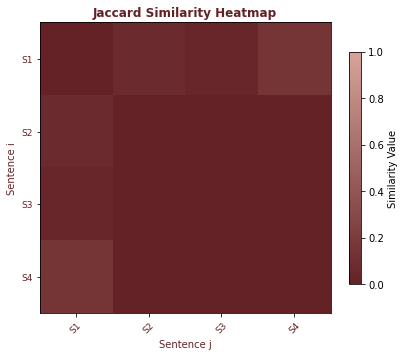

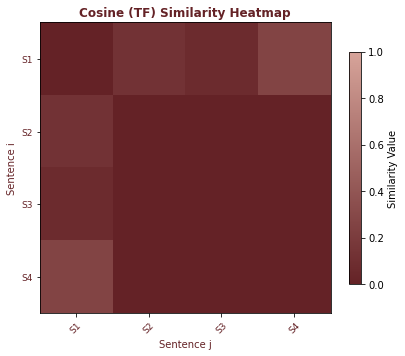

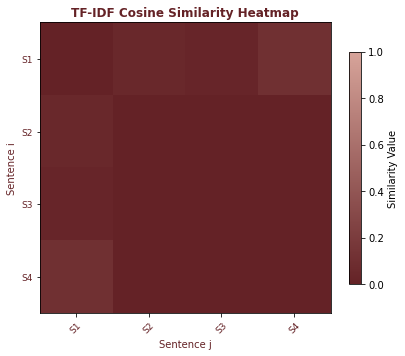

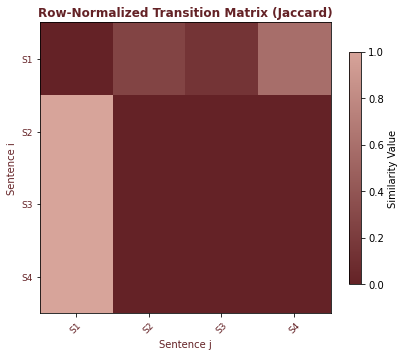

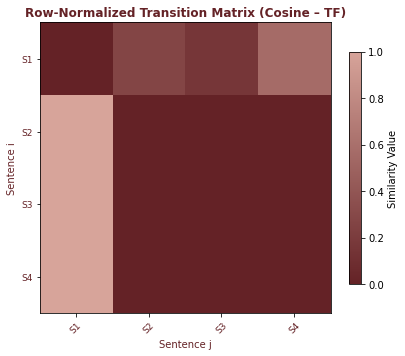

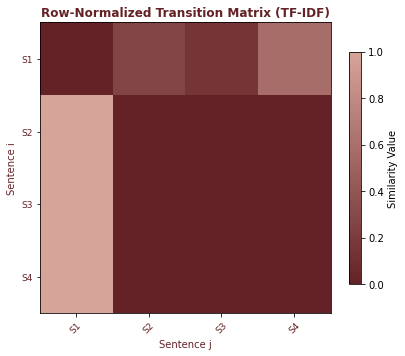

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- RUN PIPELINE ---
original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

# Build all three similarity matrices
M_jac   = build_similarity_matrix(cleaned_tokens, metric="jaccard")
M_cos   = build_similarity_matrix(cleaned_tokens, metric="cosine")
M_tfidf = build_similarity_matrix(cleaned_tokens, metric="tfidf")

# Normalize all three (for TextRank transitions)
P_jac   = row_normalize(M_jac)
P_cos   = row_normalize(M_cos)
P_tfidf = row_normalize(M_tfidf)


# --- PRINT UTILITY ---
def print_matrix(matrix, title):
    print(f"\n{title}")
    n = manual_set_length(matrix)
    for i in range(n):
        row_str = " | ".join(f"{val:.3f}" for val in matrix[i])
        print(f"Row {i+1}: {row_str}")


# --- DISPLAY SENTENCES FOR REFERENCE ---
print("\nOriginal Sentences:")
for i, s in enumerate(original_Articles):
    print(f"S{i+1}: {s}")

# --- PRINT NUMERIC MATRICES ---
print_matrix(M_jac,   "\n🔸 Jaccard Similarity Matrix")
print_matrix(M_cos,   "\n🔸 Cosine (TF) Similarity Matrix")
print_matrix(M_tfidf, "\n🔸 TF-IDF Cosine Similarity Matrix")

print_matrix(P_jac,   "\n🔹 Row-Normalized Transition Matrix – Jaccard")
print_matrix(P_cos,   "\n🔹 Row-Normalized Transition Matrix – Cosine (TF)")
print_matrix(P_tfidf, "\n🔹 Row-Normalized Transition Matrix – TF-IDF")


# --- VISUALIZATION SECTION ---
THEME_COLORS = ["#642226", "#d7a49a"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("theme_cmap", THEME_COLORS)

def plot_heatmap(matrix, title, labels):
    plt.figure(figsize=(6, 5))
    plt.imshow(matrix, cmap=custom_cmap, interpolation="nearest", vmin=0, vmax=1)
    plt.title(title, fontsize=12, fontweight="bold", color="#642226")
    plt.colorbar(label="Similarity Value", shrink=0.8)
    plt.xticks(range(len(labels)), [f"S{i+1}" for i in range(len(labels))],
               rotation=45, fontsize=9, color="#642226")
    plt.yticks(range(len(labels)), [f"S{i+1}" for i in range(len(labels))],
               fontsize=9, color="#642226")
    plt.xlabel("Sentence j", fontsize=10, color="#642226")
    plt.ylabel("Sentence i", fontsize=10, color="#642226")
    plt.tight_layout()
    plt.show()


# --- VISUALIZE ALL MATRICES ---
plot_heatmap(M_jac,   "Jaccard Similarity Heatmap", original_Articles)
plot_heatmap(M_cos,   "Cosine (TF) Similarity Heatmap", original_Articles)
plot_heatmap(M_tfidf, "TF-IDF Cosine Similarity Heatmap", original_Articles)

plot_heatmap(P_jac,   "Row-Normalized Transition Matrix (Jaccard)", original_Articles)
plot_heatmap(P_cos,   "Row-Normalized Transition Matrix (Cosine – TF)", original_Articles)
plot_heatmap(P_tfidf, "Row-Normalized Transition Matrix (TF-IDF)", original_Articles)

# CHECKED ____________


2. Graph Construction (Adjacency Matrix M)

We build the N×N matrix, where N is the number of sentences (Articles).

**Goal**

Represent each sentence as a node and the similarity between two sentences as a weighted edge.
This gives you a complete undirected weighted graph:



🔹 1. Similarity Matrix

A similarity matrix is a conceptual table of pairwise similarity values between data points.
Each cell 
S[i][j] tells you how similar two items (here, sentences) are.


The similarity can be Jaccard, Cosine, Euclidean inverse, etc.

It’s usually symmetric (
𝑆
[
𝑖
]
[
𝑗
]
=
𝑆
[
𝑗
]
[
𝑖
]
S[i][j]=S[j][i]) and dense (most entries nonzero).

You compute it purely from your data (text content, vectors, etc.).

💡 Think of it as a “semantic relationship table” — not yet a graph.

🔹 2. Adjacency Matrix

An adjacency matrix is a graph representation — it tells you which nodes are connected, and with what edge weight.

Formally:

𝑀
[
𝑖
]
[
𝑗
]
=
{
𝑤
𝑖
𝑗
	
if there is an edge between 
𝑖
 and 
𝑗


0
	
otherwise
M[i][j]={
w
ij
	​

0
	​

if there is an edge between i and j
otherwise
	​


It’s the graph version of your similarity matrix.

You can derive it from the similarity matrix:

Often just copy the values directly → fully connected weighted graph.

Or apply a threshold to drop weak edges (sparsify it).

Used by algorithms like TextRank, PageRank, etc.

💡 Think of it as the “network structure” where each sentence is a node and edges come from similarity.

| Concept                   | Computed From                    | Meaning                                | Used In                           |
| ------------------------- | -------------------------------- | -------------------------------------- | --------------------------------- |
| **Similarity Matrix (S)** | Raw sentence embeddings / tokens | Semantic similarity between every pair | Data analysis, clustering         |
| **Adjacency Matrix (M)**  | Derived from S                   | Edge weights between connected nodes   | Graph algorithms (e.g., TextRank) |


Why we are using **KNN** and how it works? 

build_similarity_matrix_dense(...) does not make the graph yet. It only builds S, the pairwise similarity table (everyone-to-everyone scores).

build_knn_adjacency(S, k=...) does make the graph. It turns S into A, where:

Nodes = sentences (S1…SN).

Edges = the non-zero entries in A (kept top-k neighbors per node, then symmetrized).

| Function                          | Job                                              | Key Output |
| --------------------------------- | ------------------------------------------------ | ---------- |
| `build_similarity_matrix_dense()` | Compute all-pair sentence similarities (dense)   | Matrix S   |
| `build_knn_adjacency()`           | Prune graph to top-k strongest edges, symmetrize | Matrix A   |
| `row_normalize()`                 | Convert A → stochastic transition matrix         | Matrix P   |
| `plot_heatmap()`                  | Visualize similarity structure                   | Heatmaps   |


### **TextRank Iteration**

The next step is to implement the core TextRank Iteration algorithm. This is the heart of the project where you iteratively calculate the Article importance scores (WS(V 
i
​
 )) until they stabilize (converge).

Step 3: TextRank Iteration Algorithm
1. Mathematical Concept: TextRank Formula
The score WS(V 
i
​
 ) for a vertex (Article) V 
i
​
  is calculated using the formula, which mimics the idea of voting by linked pages in PageRank:

WS(V 
i
​
 )=(1−d)+d⋅ 
V 
j
​
 ∈In(V 
i
​
 )
∑
​
  
∑ 
V 
k
​
 ∈Out(V 
j
​
 )
​
 w 
jk
​
 
w 
ji
​
 
​
 WS(V 
j
​
 )
Where:

WS(V 
i
​
 ): The score of the current Article i.

d: The damping factor (usually 0.85), representing the probability of "jumping" to a random Article.

w 
ji
​
 : The weight (similarity) of the edge from Article j to Article i (from your similarity matrix).

∑ 
V 
k
​
 ∈Out(V 
j
​
 )
​
 w 
jk
​
 : The normalization factor, which is the sum of all outgoing weights from Article j. This ensures that a Article with many links doesn't unfairly distribute all its weight to its neighbors.

The process starts with all scores initialized to 1.0 and continues for a set number of iterations or until the change in scores falls below a small ϵ threshold.



In [7]:
def edges_from_similarity_matrix(M, tau=0.0):
    """
    Convert dense similarity matrix to a list of edges (i, j, w) with w >= tau.
    This makes the 'graph as nodes & edges' explicit for your algorithm section.
    """
    n = manual_set_length(M)
    edges = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w = M[i][j]
            if w >= tau and w > 0.0:
                edges.append((i, j, w))
    return edges
def row_stochastic_from_edges(n, edges):
    """
    Given number of nodes n and a list of weighted edges (i, j, w),
    produce an n×n row-stochastic P where each row sums to 1.
    If a row has no outgoing weight, make it uniform.
    """
    P = [[0.0 for _ in range(n)] for __ in range(n)]
    # accumulate row sums
    row_sum = [0.0 for _ in range(n)]
    for (i, j, w) in edges:
        P[i][j] += w
        row_sum[i] += w
    # normalize rows
    for i in range(n):
        if row_sum[i] == 0.0:
            val = 1.0 / n if n > 0 else 0.0
            for j in range(n):
                P[i][j] = val
        else:
            inv = 1.0 / row_sum[i]
            for j in range(n):
                if P[i][j] != 0.0:
                    P[i][j] *= inv
    return P


In [8]:
def textrank_scores(P, d=0.85, eps=1e-6, max_iter=100):
    """
    P is ROW-stochastic (each row sums to 1).
    r^{t+1} = (1-d)/n * 1 + d * (P @ r^t)
    """
    n = manual_set_length(P)
    if n == 0:
        return []
    r = [1.0 / n for _ in range(n)]
    teleport = (1.0 - d) / n

    for _ in range(max_iter):
        r_next = [0.0 for _ in range(n)]
        # matrix-vector multiply: P @ r
        for i in range(n):
            s = 0.0
            row = P[i]
            for j in range(n):
                s += row[j] * r[j]
            r_next[i] = teleport + d * s

        # L1 convergence check
        diff = 0.0
        for i in range(n):
            diff += abs(r_next[i] - r[i])
        r = r_next
        if diff < eps:
            break
    return r


In [9]:
def select_top_k(sentences, scores, k):
    n = manual_set_length(sentences)
    k = min(k, n)
    idx = sorted(range(n), key=lambda i: scores[i], reverse=True)[:k]
    idx.sort()
    return idx, [sentences[i] for i in idx]

def select_top_k_mmr(sentences, tokens_list, base_scores, k, lam=0.8):
    # Maximal Marginal Relevance (simple): balances rank vs redundancy
    n = manual_set_length(sentences)
    k = min(k, n)
    selected, selected_set = [], set()

    def max_sim_to_selected(i):
        if not selected:
            return 0.0
        ms = 0.0
        for j in selected:
            s = jaccard_similarity_manual(tokens_list[i], tokens_list[j])
            if s > ms:
                ms = s
        return ms

    while manual_set_length(selected) < k:
        best_i, best_val = -1, -1e18
        for i in range(n):
            if i in selected_set:
                continue
            val = lam * base_scores[i] - (1.0 - lam) * max_sim_to_selected(i)
            if val > best_val:
                best_val, best_i = val, i
        selected.append(best_i)
        selected_set.add(best_i)
    selected.sort()
    return selected, [sentences[i] for i in selected]


In [10]:
def summarize_textrank(article_text, k=3, metric="jaccard", d=0.85, tau=0.0, use_mmr=False, lam=0.8):
    """
    tau: edge-pruning threshold on similarity (enforces an explicit sparse edge set).
    use_mmr: if True, apply redundancy control when selecting sentences.
    """
    # Nodes: sentences; their tokens
    sentences, tokens_list = preprocess_text_manual(article_text)

    # Edges: similarity weights between nodes
    M = build_similarity_matrix(tokens_list, metric=metric)

    # (Optional) prune weak edges to make a cleaner graph
    edges = edges_from_similarity_matrix(M, tau=tau)

    # Transition matrix P from edges
    P = row_stochastic_from_edges(manual_set_length(sentences), edges)

    # TextRank (graph algorithm)
    scores = textrank_scores(P, d=d, eps=1e-6, max_iter=100)

    # Selection
    if use_mmr:
        idx, summary = select_top_k_mmr(sentences, tokens_list, scores, k, lam=lam)
    else:
        idx, summary = select_top_k(sentences, scores, k)
    return idx, summary, scores, P, edges


In [11]:
idx, summary, scores, P_run, edges_run = summarize_textrank(
    article_text_input,
    k=3,          # top-3 sentences
    metric="jaccard",
    d=0.85,
    tau=0.05,     # prune very weak edges (tune as you like)
    use_mmr=True, # reduce redundancy
    lam=0.8
)

print("\n--- Summary ---")
for s in summary:
    print("-", s)

print("\nNode scores:")
for i, sc in enumerate(scores, 1):
    print(f"S{i}: {sc:.4f}")

print(f"\nGraph: |V|={manual_set_length(P_run)} |E|={manual_set_length(edges_run)}  (after pruning)")



--- Summary ---
- Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul.
- People enjoyed temperatures of 17C at Brighton, East Sussex, which was just shy of the year's record of 18C, set in Wales last month.
- Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade.

Node scores:
S1: 0.2500
S2: 0.2500
S3: 0.2500
S4: 0.2500

Graph: |V|=4 |E|=4  (after pruning)


Optionally add BM25 as a bonus comparison metric in your “Results & Discussion” section — show that you know it and maybe implement a simplified version on the toy example.

Code works. Just figure out everything humani tor now and make graph visualizations.

### **Discussion and Analysis (Asymptotic Complexity & Results)**

Phase	Operation	Complexity	Dominant Factor
I. Preprocessing	Tokenization and Cleaning	O(N⋅M)	Linear in the total number of words.
II. Graph Construction	Calculating N 
2
  pairwise similarities.	O(N 
2
 ⋅M)	Dominated by the N 
2
  comparisons.
III. TextRank Iteration	Matrix-Vector Multiplication (I iterations).	O(I⋅N 
2
 )	The calculation of each of the N scores involves a sum over N neighbors, repeated I times.

The overall asymptotic complexity of the TextRank algorithm, as implemented using basic Python lists, is dominated by the quadratic factors: O(N 
2
 ⋅M+I⋅N 
2
 ).

Since I (iterations) and M (average Article length) are generally small constants, the complexity is fundamentally O(N 
2
 ) with respect to the number of Articles N. This confirms why the package-free implementation is too slow for the full CNN/DailyMail dataset: scaling a quadratic algorithm to thousands of Articles becomes computationally prohibitive.